In [43]:
import pandas as pd
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import random
import re
from rdkit import Chem
from rdkit.Chem import AllChem
import selfies as sf

In [5]:
torch.cuda.empty_cache()

In [10]:
#load data
df = pd.read_csv('chembl_for_agents.csv')
selfies_list = df['selfies'].tolist()

def tokenize_selfies(selfies_str):
    return list(sf.split_selfies(selfies_str))

tokenized_selfies = [tokenize_selfies(s) for s in selfies_list]

#look at first 5 SMILES
for i in range(5):
    print(tokenized_selfies[i])

['[N]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C]', '[Branch2]', '[=Branch1]', '[O]', '[N]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C@H1]', '[Branch1]', '[#Branch2]', '[C]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[N]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C@@H1]', '[Branch1]', '[#C]', '[C]', '[C]', '[=C]', '[NH1]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch2]', '[Ring1]', '[=Branch1]', '[N]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C@@H1]', '[Branch1]', '[#C]', '[C]', '[C]', '[=C]', '[S]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch2]', '[Ring1]', '[=Branch1]', '[N]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C]', '[C]', '[C]', '[N]', '[C]', '[C]', '[Ring1]', '[=Branch1]', '[C]', '[C]', '[N]', '[C]', '[C]', '[Ring2]', '[Branch1]', '[=Branch1]']
['[O]', '[=C]', '[C]', '[C]', '[C@H1]', '[Branch2]', '[Branch1]', '[=Branch1]', '[N]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[Branch2]', '[

In [26]:
#build a vocabulary
special_tokens = ['<PAD>', '<SOS>', '<EOS>']
unique_tokens = sorted({tok for seq in tokenized_selfies for tok in seq})
vocab = special_tokens + unique_tokens

#map
token2idx = {tok: idx for idx, tok in enumerate(vocab)}
idx2token = {idx: tok for tok, idx in token2idx.items()}


#max length
max_len = max(len(seq) for seq in encoded_selfies)
print(token2idx)

#vocab length
vocab_size = len(token2idx)
vocab_size

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '.': 3, '[#Branch1]': 4, '[#Branch2]': 5, '[#C-1]': 6, '[#C]': 7, '[#N+1]': 8, '[#N]': 9, '[#O+1]': 10, '[-/Ring2]': 11, '[-\\Ring2]': 12, '[/123I]': 13, '[/Br]': 14, '[/C@@H1]': 15, '[/C@H1]': 16, '[/C@]': 17, '[/C]': 18, '[/Cl]': 19, '[/F]': 20, '[/I]': 21, '[/N+1]': 22, '[/N]': 23, '[/O-1]': 24, '[/O]': 25, '[/P]': 26, '[/S]': 27, '[11CH3]': 28, '[11C]': 29, '[123I-1]': 30, '[123I]': 31, '[124I]': 32, '[125I-1]': 33, '[125I]': 34, '[127Xe]': 35, '[129Xe]': 36, '[131Cs]': 37, '[131I-1]': 38, '[131I]': 39, '[133Xe]': 40, '[13C]': 41, '[13NH3]': 42, '[14C]': 43, '[15OH2]': 44, '[18F-1]': 45, '[18F]': 46, '[223Ra]': 47, '[2H]': 48, '[68Ga+3]': 49, '[75Se]': 50, '[81Kr]': 51, '[82Rb+1]': 52, '[82Rb]': 53, '[89Sr+2]': 54, '[=32P]': 55, '[=As]': 56, '[=Branch1]': 57, '[=Branch2]': 58, '[=C]': 59, '[=Mg]': 60, '[=N+1]': 61, '[=N-1]': 62, '[=N]': 63, '[=O+1]': 64, '[=O]': 65, '[=P@]': 66, '[=PH1]': 67, '[=P]': 68, '[=Ring1]': 69, '[=Ring2]': 70, '[=S+1]':

180

In [27]:
#find max seq length
max_len = max([len(s) for s in tokenized_selfies])
print(max_len)


1020


In [30]:
def encode(selfies, token2idx, max_len):

    #add sos and eos tokens
    tokens = [token2idx['<SOS>']] + [token2idx[tok] for tok in selfies] + [token2idx['<EOS>']]

    #padding
    if len(tokens) < max_len:
        tokens += [token2idx['<PAD>']]*(max_len - len(tokens)) 

    else:
        tokens = tokens[:max_len] #truncation

    return tokens


In [31]:
#test function
print(tokenized_selfies[0])
encoded_selfies = [encode(seq, token2idx, max_len) for seq in tokenized_selfies]
print(token2idx['[N]'])
print(token2idx['[C]'])
print(token2idx['[=O]'])
encoded_selfies[0]


['[N]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C]', '[Branch2]', '[=Branch1]', '[O]', '[N]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C@H1]', '[Branch1]', '[#Branch2]', '[C]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[N]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C@@H1]', '[Branch1]', '[#C]', '[C]', '[C]', '[=C]', '[NH1]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch2]', '[Ring1]', '[=Branch1]', '[N]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C@@H1]', '[Branch1]', '[#C]', '[C]', '[C]', '[=C]', '[S]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch2]', '[Ring1]', '[=Branch1]', '[N]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C]', '[C]', '[C]', '[N]', '[C]', '[C]', '[Ring1]', '[=Branch1]', '[C]', '[C]', '[N]', '[C]', '[C]', '[Ring2]', '[Branch1]', '[=Branch1]']
127
97
65


[1,
 127,
 97,
 57,
 97,
 65,
 97,
 89,
 57,
 135,
 127,
 97,
 57,
 97,
 65,
 94,
 88,
 5,
 97,
 97,
 59,
 97,
 59,
 97,
 59,
 145,
 57,
 127,
 97,
 57,
 97,
 65,
 92,
 88,
 7,
 97,
 97,
 59,
 126,
 97,
 59,
 97,
 59,
 97,
 59,
 145,
 58,
 145,
 57,
 127,
 97,
 57,
 97,
 65,
 92,
 88,
 7,
 97,
 97,
 59,
 155,
 97,
 59,
 97,
 59,
 97,
 59,
 145,
 58,
 145,
 57,
 127,
 97,
 57,
 97,
 65,
 97,
 97,
 97,
 127,
 97,
 97,
 145,
 57,
 97,
 97,
 127,
 97,
 97,
 146,
 88,
 57,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,

In [24]:
class MoleculeDataset(Dataset):
    def __init__(self, selfies_list, token2idx, max_len):
        self.selfies = selfies_list
        self.max_len = max_len
        self.token2idx = token2idx

    def __len__(self):
        return len(self.selfies)

    def __getitem__(self, idx):
        encoded = encode(self.selfies[idx], self.token2idx, self.max_len)
        return torch.tensor(encoded, dtype=torch.long)

In [33]:
#collate function for decoder input and target

def collate_fn(batch):

    batch = torch.stack(batch, dim=0)  # (batch_size, seq_len)

    #decoder input is all but last token eos
    decoder_input = batch[:, :-1] #with sos

    #target is all but first token sos
    target = batch[:, 1:] #with eos

    return decoder_input, target

In [34]:
#create dataset and dataloader
dataset = MoleculeDataset(tokenized_selfies, token2idx, max_len=max_len)  
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
dataset[0]

tensor([  1, 127,  97,  ...,   0,   0,   0])

In [36]:
#defining a LSTM(RNN) VAE model

### MODEL ARCHITECTURE ###
class SMILEVAE(nn.Module):
    def __init__(self, vocab_size, embed_size=64, hidden_size=128, latent_size=64, max_len=120):
        super (SMILEVAE, self).__init__()

        #create embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=token2idx['<PAD>']) 

        #encoder layers
        self.encoder_lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.hidden2mean = nn.Linear(hidden_size, latent_size)
        self.hidden2logvar = nn.Linear(hidden_size, latent_size)

        #decoder layers
        self.latent2hidden = nn.Linear(latent_size, hidden_size)
        self.decoder_lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)

        #output layer
        self.outputs2vocab = nn.Linear(hidden_size, vocab_size)

    
    def encode(self, x):
        x = self.embed(x)
        _, (h, _) = self.encoder_lstm(x) #only take final hidden state
        h = h[-1] #last layer only
        mean = self.hidden2mean(h)
        logvar = self.hidden2logvar(h)
        
        return mean, logvar
    
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)

        return mean + eps*std
    

    def decode(self, z, x=None):
        h = self.latent2hidden(z).unsqueeze(0) #z:(batch, latent_size)
        c = torch.zeros_like(h) #initial cell state
        batch_size = z.size(0)

        #input token
        if x is None: #inference mode
            x_in = torch.zeros(batch_size, self.max_len, dtype=torch.long, device=z.device)#start with all padding tokens
            
        else: #training mode
            x_in = x

        x_emb = self.embed(x_in)
        out, _ = self.decoder_lstm(x_emb, (h, c))
        logits = self.outputs2vocab(out)

        return logits
    

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        logits = self.decode(z, x)

        return logits, mean, logvar

In [37]:
#training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SMILEVAE(vocab_size=vocab_size, embed_size=64, hidden_size=128, latent_size=64, max_len=max_len).to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)

In [38]:
#loss funtion
def vae_loss( logits, target, mean, logvar):
    
    #flatten logits and target for cross-entropy loss
    logits_flat = logits.reshape(-1, logits.size(-1))  # (batch_size*seq_len, vocab_size)
    target_flat = target.reshape(-1)  # (batch_size*seq_len)

    #Reconstruction Loss
    recon_loss = F.cross_entropy(logits_flat, target_flat, ignore_index=token2idx['<PAD>'])

    #KL Divergence Loss
    kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

    return recon_loss + kl_loss, recon_loss, kl_loss
    
    

In [39]:
#testing
batch_size = 4  # dummy small batch
dummy_input = torch.randint(1, vocab_size, (batch_size, max_len)).to(device)

model.eval()
with torch.no_grad():
    logits, mean, logvar = model(dummy_input)

print("Input Shape:", dummy_input.shape)
print("Output logits:", logits.shape)
print("Latent Mean:", mean.shape)
print("Latent LogVar:", logvar.shape)

Input Shape: torch.Size([4, 1020])
Output logits: torch.Size([4, 1020, 180])
Latent Mean: torch.Size([4, 64])
Latent LogVar: torch.Size([4, 64])


In [40]:
for decoder_input, target in dataloader:

    print(decoder_input.shape, target.shape)
    break

torch.Size([64, 1019]) torch.Size([64, 1019])


In [41]:
####  WARNING: TRAINING LOOP EXECUTION ####

#training loop

#record
loss_arr = []
recon_arr = []
kl_arr = []

epochs = 20

model.train()
print("Current device:", device)

for epoch in range(1, epochs+1):
    total_loss = 0
    total_recon = 0
    total_kl = 0

    for decoder_input, target in dataloader:

        decoder_input = decoder_input.to(device)
        target = target.to(device)

        optimiser.zero_grad()
        logits, mean, logvar = model(decoder_input)

        loss, recon_loss, kl_loss = vae_loss(logits, target, mean, logvar)
        loss.backward()
        optimiser.step()

        total_loss += loss.item() * decoder_input.size(0)
        total_recon += recon_loss.item() * decoder_input.size(0)
        total_kl += kl_loss.item() * decoder_input.size(0)

    avg_loss = total_loss / len(dataloader.dataset)
    avg_recon = total_recon / len(dataloader.dataset)   
    avg_kl = total_kl / len(dataloader.dataset)

    #append to array
    loss_arr.append(avg_loss)
    recon_arr.append(avg_recon)
    kl_arr.append(avg_kl)

    print(f'Epoch {epoch}, Loss: {avg_loss:.4f}, Recon Loss: {avg_recon:.4f}, KL Loss: {avg_kl:.4f}')


Current device: cuda
Epoch 1, Loss: 2.4008, Recon Loss: 2.3980, KL Loss: 0.0028
Epoch 2, Loss: 1.7817, Recon Loss: 1.7817, KL Loss: 0.0000
Epoch 3, Loss: 1.6229, Recon Loss: 1.6229, KL Loss: 0.0000
Epoch 4, Loss: 1.5264, Recon Loss: 1.5264, KL Loss: 0.0000
Epoch 5, Loss: 1.4596, Recon Loss: 1.4596, KL Loss: 0.0000
Epoch 6, Loss: 1.4052, Recon Loss: 1.4052, KL Loss: 0.0000
Epoch 7, Loss: 1.3604, Recon Loss: 1.3604, KL Loss: 0.0000
Epoch 8, Loss: 1.3231, Recon Loss: 1.3231, KL Loss: 0.0000
Epoch 9, Loss: 1.2931, Recon Loss: 1.2931, KL Loss: 0.0000
Epoch 10, Loss: 1.2671, Recon Loss: 1.2671, KL Loss: 0.0000
Epoch 11, Loss: 1.2451, Recon Loss: 1.2451, KL Loss: 0.0000
Epoch 12, Loss: 1.2245, Recon Loss: 1.2245, KL Loss: 0.0000
Epoch 13, Loss: 1.2061, Recon Loss: 1.2061, KL Loss: 0.0000
Epoch 14, Loss: 1.1901, Recon Loss: 1.1901, KL Loss: 0.0000
Epoch 15, Loss: 1.1773, Recon Loss: 1.1773, KL Loss: 0.0000
Epoch 16, Loss: 1.1641, Recon Loss: 1.1641, KL Loss: 0.0000
Epoch 17, Loss: 1.1506, Reco

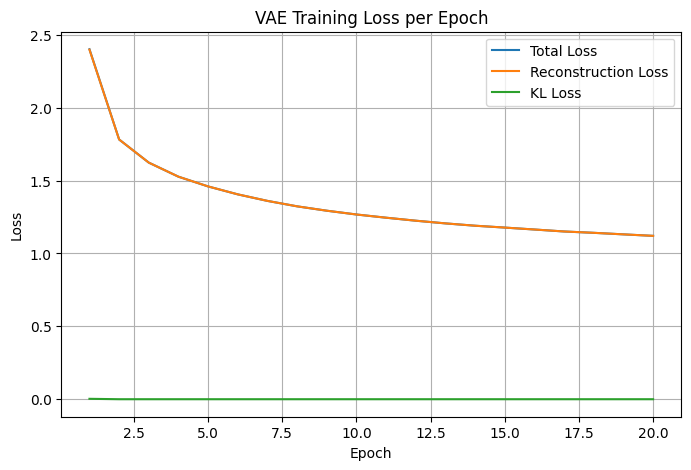

In [42]:
#plot loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), loss_arr, label='Total Loss')
plt.plot(range(1, epochs+1), recon_arr, label='Reconstruction Loss')
plt.plot(range(1, epochs+1), kl_arr, label='KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
def postprocess_output(batch_indices, idx2token):
    
    results = []

    for seq in batch_indices:
        # 1. idx to token
        tokens = [idx2token[int(i)] for i in seq if int(i) in idx2token]

        # 2. remove sos eos pad
        tokens = [tok for tok in tokens if tok not in ("<SOS>", "<EOS>", "<PAD>")]

        # 3. join all
        selfies_str = "".join(tokens)

        # 4. convert selfies to smiles
        try:
            smiles = sf.decoder(selfies_str)  
        except Exception:
            smiles = "INVALID"

        # 5. Validate & sanitize SMILES
        if smiles != "INVALID":
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    smiles = "INVALID"
                else:
                    AllChem.SanitizeMol(mol)
                    smiles = Chem.MolToSmiles(mol, canonical=True)
            except Exception:
                smiles = "INVALID"

        results.append({
            "selfies": selfies_str,
            "smiles": smiles
        })

    return results

In [47]:
#test reconstruction capability

def test_reconstruction(model, dataset, idx2token, device, num_samples=5):
    model.eval()
    
    #load first 5 samples from dataset
    input_seqs = torch.stack([dataset[i] for i in range(num_samples)]).to(device)  # (N, seq_len)
    
    with torch.no_grad():
        logits, _, _ = model(input_seqs)  # logits: (batch, seq_len, vocab_size)
        predicted_indices = torch.argmax(logits, dim=-1)  # (batch, seq_len)
    
    # 2. Post-processing
    reconstructed = postprocess_output(predicted_indices, idx2token)
    
    for i in range(num_samples):
        original_selfies_tokens = [idx2token[int(j)] for j in input_seqs[i] if int(j) in idx2token]
        original_selfies = "".join([tok for tok in original_selfies_tokens if tok not in ("<SOS>", "<EOS>", "<PAD>")])
        
        print(f" SAMPLE {i+1} ")
        print(f"Original SELFIES:  {original_selfies}")
        print(f"Reconstructed SELFIES: {reconstructed[i]['selfies']}")
        print(f"Reconstructed SMILES:  {reconstructed[i]['smiles']}")

In [48]:
test_reconstruction(model, dataset, idx2token, device)

 SAMPLE 1 
Original SELFIES:  [N][C][=Branch1][C][=O][C][Branch2][=Branch1][O][N][C][=Branch1][C][=O][C@H1][Branch1][#Branch2][C][C][=C][C][=C][C][=C][Ring1][=Branch1][N][C][=Branch1][C][=O][C@@H1][Branch1][#C][C][C][=C][NH1][C][=C][C][=C][C][=C][Ring1][=Branch2][Ring1][=Branch1][N][C][=Branch1][C][=O][C@@H1][Branch1][#C][C][C][=C][S][C][=C][C][=C][C][=C][Ring1][=Branch2][Ring1][=Branch1][N][C][=Branch1][C][=O][C][C][C][N][C][C][Ring1][=Branch1][C][C][N][C][C][Ring2][Branch1][=Branch1]
Reconstructed SELFIES: [C][C][=Branch1][C][=O][C][=C][Ring1][#Branch1][C][C][=Branch1][C][=O][C][Branch1][#Branch2][C][C][=C][C][=C][C][=C][Ring1][=Branch1][N][C][=Branch1][C][=O][C@H1][C][C][C][C][=C][NH1][C][=C][C][=C][C][=C][Ring1][=Branch2][Ring1][=Branch1][N][C][=Branch1][C][=O][C@H1][C][C][C][C][=C][NH1][C][Branch1][C][=C][C][=C][Ring1][=Branch2][Ring1][=Branch1][N][C][=Branch1][C][=O][C@H1][C][C][C][C][=Branch1][N][=Branch1][C][=Branch1][C][Ring2][=Branch1][C][Ring1][C][C][=Branch1][C][Ring2][Ring